In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from final_project import loader, builder, models, plots
from final_project.models import ModelENUM
from pathlib import Path
from sklearn.model_selection import train_test_split

In [3]:
df = loader.get_df(all_files=True)
df = df[df['Origin'] == 'BOS']
df = df[[
    'DistanceGroup',
    'DayofMonth',
    'Month',
    'Year',
    'Duplicate',
    'ArrDel15',
    'DistanceGroup',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'Operating_Airline',
    'Dest'
]]
df = builder.encodeFrame(df)

delay_df = df[df['ArrDel15'] > 0.5].sample(n=2000)
on_time_df = df[df['ArrDel15'] <= 0.5].sample(n=8000)
sample_df = pd.concat([delay_df, on_time_df], ignore_index=True)


x = sample_df.drop(columns=['ArrDel15'])
y = sample_df[['ArrDel15']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=150)

In [8]:
svm_pipeline = models.get_pipeline(ModelENUM.SVM)
param_grid = [
    models.get_svm_param(gamma=['auto'], c_list=[.001, .01, 1, 10], coef0=[0, 1, 2], kernel=['linear', 'rbf'], max_iter=[5000])
    # models.get_svm_param(gamma=[2, 3, 4, 'scale', 'auto'], c_list=[1e-2, 1e-1, 1e1, 1e2], coef0=[0, 1, 2], kernel=['linear', 'poly', 'rbf'])
    # models.get_svm_param(gamma=[2], c_list=[1e-2], coef0=[1], kernel=['linear'])
]
grid_search = models.get_grid_search_cv(
    pipeline=svm_pipeline, param_grid=param_grid, cv=3, n_jobs=40
)

In [9]:
svm_model = grid_search.fit(x_train, y_train.to_numpy().ravel())

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3; 1/27] START svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True
[CV 2/3; 1/27] START svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True
[CV 3/3; 3/27] START svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True
[CV 3/3; 1/27] START svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True[CV 2/3; 7/27] START svm__C=0.001, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True

[CV 1/3; 4/27] START svm__C=0.001, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True
[CV 2/3; 4/27] START svm__C=0.001, svm__ca

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 13/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.558 total time= 1.6min
[CV 2/3; 14/27] START svm__C=0.01, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True
[CV 3/3; 10/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.607 total time= 1.7min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 14/27] START svm__C=0.01, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True
[CV 1/3; 1/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.372 total time= 1.8min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 15/27] START svm__C=0.01, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True
[CV 2/3; 10/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.558 total time= 1.7min
[CV 2/3; 15/27] START svm__C=0.01, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 4/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.331 total time= 1.8min
[CV 2/3; 7/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.339 total time= 1.8min
[CV 3/3; 15/27] START svm__C=0.01, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 16/27] START svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True
[CV 3/3; 6/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.665 total time= 1.9min
[CV 2/3; 16/27] START svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 13/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.644 total time= 1.9min
[CV 3/3; 16/27] START svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 4/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.372 total time= 2.0min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 17/27] START svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True
[CV 3/3; 1/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.331 total time= 2.0min
[CV 2/3; 17/27] START svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 10/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.644 total time= 2.0min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 4/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.339 total time= 2.0min
[CV 3/3; 17/27] START svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True
[CV 1/3; 18/27] START svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 13/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.607 total time= 2.0min
[CV 1/3; 7/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.372 total time= 2.1min
[CV 2/3; 18/27] START svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True
[CV 3/3; 18/27] START svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 3/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.724 total time= 2.2min
[CV 1/3; 19/27] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True
[CV 2/3; 1/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.339 total time= 2.2min
[CV 2/3; 19/27] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 6/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.646 total time= 2.2min
[CV 3/3; 19/27] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 7/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.331 total time= 2.3min
[CV 1/3; 20/27] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-process

[CV 3/3; 8/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.498 total time= 2.4min
[CV 2/3; 9/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.646 total time= 2.4min
[CV 2/3; 20/27] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True
[CV 3/3; 20/27] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True[CV 2/3; 8/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.468 total time= 2.4min

[CV 1/3; 21/27] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 6/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.724 total time= 2.5min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 9/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.665 total time= 2.4min
[CV 2/3; 21/27] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True
[CV 3/3; 21/27] START svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True
[CV 2/3; 11/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.671 total time= 2.4min
[CV 1/3; 5/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.578 total time= 2.5min
[CV 1/3; 22/27] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True
[CV 2/3; 22/27] START s

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 5/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.495 total time= 2.5min
[CV 3/3; 22/27] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True
[CV 1/3; 2/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.761 total time= 2.5min
[CV 1/3; 23/27] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-process

[CV 1/3; 9/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.724 total time= 2.7min
[CV 1/3; 11/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.760 total time= 2.6min
[CV 3/3; 5/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.440 total time= 2.7min
[CV 2/3; 23/27] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True
[CV 3/3; 23/27] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True
[CV 1/3; 24/27] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 12/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.599 total time= 2.7min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 24/27] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True
[CV 3/3; 3/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.665 total time= 2.7min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 19/27] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.495 total time=  31.2s
[CV 3/3; 24/27] START svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True
[CV 1/3; 25/27] START svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True
[CV 2/3; 3/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.646 total time= 2.7min
[CV 2/3; 25/27] START svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True
[CV 3/3; 12/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.635 total time= 2.7min
[CV 3/3; 11/27] END svm__C=0

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 2/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.667 total time= 2.8min
[CV 3/3; 26/27] START svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True
[CV 1/3; 8/27] END svm__C=0.001, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.509 total time= 2.8min
[CV 1/3; 27/27] START svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 14/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.511 total time= 2.9min
[CV 2/3; 27/27] START svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True
[CV 1/3; 12/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.694 total time= 3.0min
[CV 3/3; 27/27] START svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 19/27] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.481 total time=  59.6s


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 19/27] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.459 total time= 1.1min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 22/27] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.495 total time= 1.1min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 16/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.558 total time= 1.7min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 16/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.644 total time= 1.8min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 25/27] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.459 total time=  55.8s


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 22/27] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.459 total time= 1.1min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 16/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.607 total time= 1.8min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 22/27] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.481 total time= 1.3min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 17/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.433 total time= 1.7min
[CV 1/3; 25/27] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.481 total time= 1.1min
[CV 2/3; 15/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.599 total time= 2.1min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 25/27] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=1000, svm__probability=True;, score=0.495 total time= 1.1min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 15/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.694 total time= 2.2min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 20/27] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.630 total time= 1.7min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 14/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.500 total time= 2.4min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-process

[CV 3/3; 14/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.496 total time= 2.5min
[CV 2/3; 17/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.497 total time= 2.2min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 21/27] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.538 total time= 1.7min
[CV 2/3; 18/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.599 total time= 2.1min
[CV 3/3; 18/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.635 total time= 2.1min
[CV 1/3; 17/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.448 total time= 2.2min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 20/27] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.596 total time= 1.8min
[CV 2/3; 20/27] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.524 total time= 1.8min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 15/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.635 total time= 2.4min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 21/27] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.470 total time= 1.8min
[CV 1/3; 18/27] END svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.694 total time= 2.2min
[CV 1/3; 21/27] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.585 total time= 1.8min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 24/27] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.585 total time= 1.7min
[CV 1/3; 23/27] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.566 total time= 1.8min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 24/27] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.538 total time= 1.6min
[CV 1/3; 27/27] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.585 total time= 1.6min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 23/27] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.397 total time= 1.7min
[CV 2/3; 24/27] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.470 total time= 1.7min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-process

[CV 2/3; 27/27] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.470 total time= 1.5min
[CV 3/3; 26/27] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.615 total time= 1.6min
[CV 3/3; 27/27] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=1000, svm__probability=True;, score=0.538 total time= 1.3min
[CV 3/3; 23/27] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.441 total time= 1.7min
[CV 1/3; 26/27] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.423 total time= 1.7min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 26/27] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=sigmoid, svm__max_iter=1000, svm__probability=True;, score=0.574 total time= 1.6min


In [10]:
print(models.get_best_params(models.ModelENUM.SVM, svm_model))

{'gamma': 'auto', 'kernel': 'sigmoid', 'C': 0.001}


414


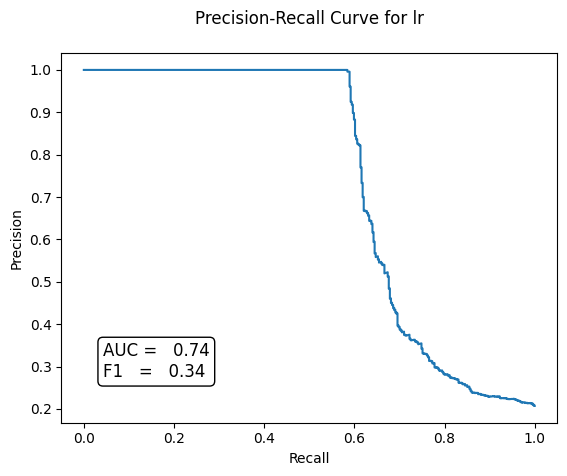

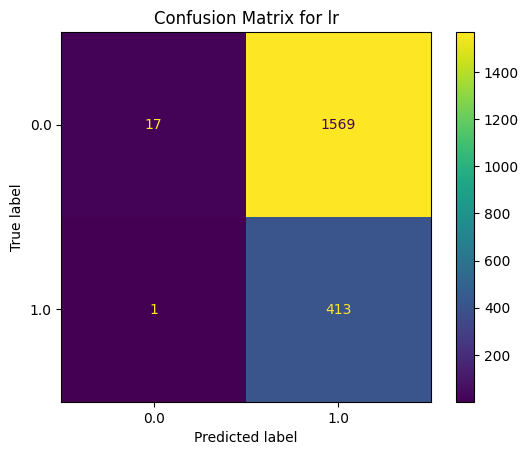

In [11]:
number_true = np.count_nonzero(y_test == 1)
print(number_true)

y_prob = svm_model.predict_proba(x_test)[:, 1]
y_pred = svm_model.predict(x_test)
plots.save_precision_recall_curve("lr", "test_file", y_test, y_prob)
plots.save_confusion_matrix("lr", "test_file", y_test, y_pred)